<a href="https://colab.research.google.com/github/tc10767557/Portfolio/blob/main/Introductory%20Markov%20Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Teagan Clark

Dr. Saghafi

DSC for Sports

11 October 2024

# Homework 2 - Due Oct 11, 2024


Read the following instructions:
* The use of AI for answering is prohibited. You should accomplish required tasks using codes discussed in the class.

* New data are available on Canvas > supplementary.

* Only requested answers are to be written and submitted, extra codes/explanations have negative points.

* If explanation/comment is requested in the question, open a text block and type in your answer there.

* All prints should have text that descrie what the printed item is.

* Late submission penalty: one point per day one week after the submission deadline.

In [ ]:
# DO NOT ADD/REMOVE/CHANGE THIS BLOCK
# Loading required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.patches as mpatches

from scipy.stats import binom
from scipy.stats import norm
from IPython.display import Image
from graphviz import Digraph
from matplotlib.collections import PatchCollection

In [ ]:
# DO NOT ADD/REMOVE/CHANGE THIS BLOCK
# Connect your Google Colab to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Helper Functions

In [ ]:
# Define some helper functions
class Node():

    def __init__(
        self, center, radius, label,
        facecolor='#2653de', edgecolor='#e6e6e6',
        ring_facecolor='#a3a3a3', ring_edgecolor='#a3a3a3',
        **kwargs
        ):
        """
        Initializes a Markov Chain Node(for drawing purposes)
        Inputs:
            - center : Node (x,y) center
            - radius : Node radius
            - label  : Node label
        """
        self.center = center
        self.radius = radius
        self.label  = label

        # For convinience: x, y coordinates of the center
        self.x = center[0]
        self.y = center[1]

        # Drawing config
        self.node_facecolor = facecolor
        self.node_edgecolor = edgecolor

        self.ring_facecolor = ring_facecolor
        self.ring_edgecolor = ring_edgecolor
        self.ring_width = 0.03

        self.text_args = {
            'ha': 'center',
            'va': 'center',
            'fontsize': kwargs.get("node_fontsize", 12)
        }


    def add_circle(self, ax):
        """
        Add the annotated circle for the node
        """
        circle = mpatches.Circle(self.center, self.radius)
        p = PatchCollection(
            [circle],
            edgecolor = self.node_edgecolor,
            facecolor = self.node_facecolor
        )
        ax.add_collection(p)
        ax.annotate(
            self.label,
            xy = self.center,
            color = '#ffffff',
            **self.text_args
        )


    def add_self_loop(self, ax, prob=None, direction='up', annotate = True, percentages = False):
        """
        Draws a self loop
        """
        if direction == 'up':
            start = -30
            angle = 180
            ring_x = self.x
            ring_y = self.y + self.radius
            prob_y = self.y + 1.3*self.radius
            x_cent = ring_x - self.radius + (self.ring_width/2)
            y_cent = ring_y - 0.15
        else:
            start = -210
            angle = 0
            ring_x = self.x
            ring_y = self.y - self.radius
            prob_y = self.y - 1.4*self.radius
            x_cent = ring_x + self.radius - (self.ring_width/2)
            y_cent = ring_y + 0.15

        # Add the ring
        ring = mpatches.Wedge(
            (ring_x, ring_y),
            self.radius,
            start,
            angle,
            width = self.ring_width
        )
        # Add the triangle (arrow)
        offset = 0.2
        left   = [x_cent - offset, ring_y]
        right  = [x_cent + offset, ring_y]
        bottom = [(left[0]+right[0])/2., y_cent]
        arrow  = plt.Polygon([left, right, bottom, left])

        p = PatchCollection(
            [ring, arrow],
            edgecolor = self.ring_edgecolor,
            facecolor = self.ring_facecolor
        )
        ax.add_collection(p)

        # Probability to add?
        if prob and annotate:
            text = f"{prob*100 if percentages else prob:.1f}".rstrip("0").rstrip(".")
            text += "%" if percentages else ""
            ax.annotate(text, xy=(self.x, prob_y), color='#000000', **self.text_args)


class MarkovChain:

    def __init__(self, M, labels, **kwargs):
        """
        Initializes a Markov Chain (for drawing purposes)
        Inputs:
            - M         Transition Matrix
            - labels    State Labels
            - kwargs    Keywords to modify how data is displayed, specifically:
                        annotate          if False, probabilities aren't shown
                        arrow_edgecolor
                        arrow_facecolor
                        arrow_head_width
                        arrow_width
                        fontsize          affects transition probability labels
                        node_edgecolor
                        node_facecolor
                        node_fontsize     affects node labels
                        node_radius
                        percentages       bool, if True probabilites should be
                                          displayed as percentages instead of decimals
                        transparency_func function to determine transparency of arrows (default: alpha = prob)
        """

        np.set_printoptions(precision=3,suppress=True)

        if M.shape[0] < 2:
            raise Exception("There should be at least 2 states")
        if M.shape[0] != M.shape[1]:
            raise Exception("Transition matrix should be square")
        if M.shape[0] != len(labels):
            raise Exception("There should be as many labels as states")

        # save args
        self.M = M
        self.n_states = M.shape[0]
        self.labels = labels

        self.save_kwargs(**kwargs)

        # Build the network
        self.build_network()


    def save_kwargs(self, **kwargs):

        # save the dictionary
        self.kwargs = kwargs

        # Colors
        self.arrow_facecolor = self.kwargs.get("arrow_facecolor", '#a3a3a3')
        self.arrow_edgecolor = self.kwargs.get("arrow_edgecolor", '#a3a3a3')
        self.node_facecolor = self.kwargs.get("node_facecolor", '#2693de')
        self.node_edgecolor = self.kwargs.get("node_edgecolor", '#e6e6e6')

        # Drawing config
        self.node_radius = self.kwargs.get("node_radius", 0.60)
        self.arrow_width = self.kwargs.get("arrow_width", 0.1)
        self.arrow_head_width = self.kwargs.get("arrow_head_width", 0.22)
        self.text_args = {
            'ha': 'center',
            'va': 'center',
            'fontsize': self.kwargs.get("fontsize", 14)
        }

        # How to represent the probabilities
        self.percentages = self.kwargs.get("percentages", False)
        self.annotate_probabilities = self.kwargs.get("annotate", True)
        self.transparency_func = self.kwargs.get("transparency_func", lambda p: p)


    def set_node_centers(self):
        """
            Spread the nodes evenly around in a circle using Euler's formula
            e^(2pi*i*k/n), where n is the number of nodes and k is the
            index over which we iterate. The real part is the x coordinate,
            the imaginary part is the y coordinate. Then scale by n for more room.

            self.node_centers is a numpy array of shape (n,2)
        """

        # For legibility, we use n below
        n = self.n_states

        # generate the evenly spaced coords on the unit circle
        unit_circle_coords = np.fromfunction(lambda x,y:
                        (1-y)*np.real(np.exp(2 * np.pi * x/n * 1j))
                        + y * np.imag(np.exp(2 * np.pi * x/n * 1j)),
                        (n,2))

        self.figsize = (n*2+2, n*2+2)
        self.xlim = (-n-1, n+1)
        self.ylim = (-n-1, n+1)

        # Scale by n to have more room
        self.node_centers = unit_circle_coords * n


    def build_network(self):
        """
        Loops through the matrix, add the nodes
        """
        # Position the node centers
        self.set_node_centers()

        # Set the nodes
        self.nodes = [Node(self.node_centers[i],
                           self.node_radius,
                           self.labels[i],
                           **self.kwargs) for i in range(self.n_states)]


    def add_arrow(self, ax,
                  node1, node2,
                  prob=None, width=None,
                  head_width=None,
                  annotate = True,
                  arrow_spacing = 0.15,
                  transparency_func = None):
        """
        Add a directed arrow between two nodes

        Keywords:

        annotate:                if True, probability is displayed on top of the arrow
        arrow_spacing:           determines space between arrows in opposite directions
        head_width:              width of arrow head
        prob:                    probability of going from node1 to node2
        transparency_func:       function to determine transparency of arrows
        width:                   width of arrow body
        """

        if width is None:
            width = self.arrow_width
        if head_width is None:
            head_width = self.arrow_head_width
        if transparency_func is None:
            transparency_func = self.transparency_func

        # x,y start of the arrow, just touching the starting node
        x_start = node1.x + node1.radius*(node2.x-node1.x)/np.linalg.norm(node2.center-node1.center)
        y_start = node1.y + node1.radius*(node2.y-node1.y)/np.linalg.norm(node2.center-node1.center)

        # find the arrow length so it just touches the ending node
        dx = node2.x-x_start - node2.radius*(node2.x-node1.x)/np.linalg.norm(node2.center-node1.center)
        dy = node2.y-y_start - node2.radius*(node2.y-node1.y)/np.linalg.norm(node2.center-node1.center)

        # calculate offset so arrows in opposite directions are separate

        x_offset = dy / np.sqrt(dx**2+dy**2) * arrow_spacing
        y_offset = -dx / np.sqrt(dx**2+dy**2) * arrow_spacing

        arrow = mpatches.FancyArrow(
            x_start + x_offset,
            y_start + y_offset,
            dx,
            dy,
            width = width,
            head_width = head_width,
            length_includes_head = True
        )
        p = PatchCollection(
            [arrow],
            edgecolor = self.arrow_edgecolor,
            facecolor = self.arrow_facecolor,
            alpha = transparency_func(prob)
        )
        ax.add_collection(p)

        # Add label of probability at coordinates (x_prob, y_prob)
        x_prob = x_start +  0.2*dx + 1.2 * x_offset
        y_prob = y_start +  0.2*dy + 1.2 * y_offset
        if prob and annotate:
            text = f"{prob*100 if self.percentages else prob:.1f}".rstrip("0").rstrip(".")
            text += "%" if self.percentages else ""
            ax.annotate(text, xy=(x_prob, y_prob), color='#000000', **self.text_args)


    def draw(self, img_path=None):
        """
        Draw the Markov Chain
        """
        fig, ax = plt.subplots(figsize=self.figsize)

        # Set the axis limits
        plt.xlim(self.xlim)
        plt.ylim(self.ylim)

        # Draw the nodes
        for node in self.nodes:
            node.add_circle(ax)

        # Add the transitions
        for i in range(self.M.shape[0]):
            for j in range(self.M.shape[1]):
                # self loops
                if i == j and self.M[i,i] > 0:
                    self.nodes[i].add_self_loop(ax,
                                                prob = self.M[i,j],
                                                direction = 'up' if self.nodes[i].y >= 0 else 'down',
                                                annotate = self.annotate_probabilities,
                                                percentages = self.percentages)

                # directed arrows
                elif self.M[i,j] > 0:
                    self.add_arrow(ax,
                                   self.nodes[i],
                                   self.nodes[j],
                                   prob = self.M[i,j],
                                   annotate = self.annotate_probabilities)

        plt.axis('off')
        # Save the image to disk?
        if img_path:
            plt.savefig(img_path)
        plt.show()

In [ ]:
# Define transition counting matrix
def get_transition_tuples(ls):
    ''' Converts a list into a list of transition tuples
    '''
    return [(ls[i-1], ls[i]) for i in range(1, len(ls))]

# Define functions to visualize transition matrices as graphs
def get_df_edgelist(df, ls_index):
    ''' Derive an edge list with weight values
    '''
    edgelist = []
    for i in ls_index:
        for j in ls_index:
            edgelist.append([i, j, df[j][i]])
    return pd.DataFrame(edgelist, columns=['src', 'dst', 'weight'])

def edgelist_to_digraph(df_edgelist):
    ''' Convert an edge list into a weighted directed graph
    '''
    g = Digraph(format='jpeg')
    g.attr(rankdir='LR', size='30')
    g.attr('node', shape='circle')
    nodelist = []
    for _, row in df_edgelist.iterrows():
        node1, node2, weight = [str(item) for item in row]
        if node1 not in nodelist:
            g.node(node1, **{'width': '1', 'height': '1'})
            nodelist.append(node1)
        if node2 not in nodelist:
            g.node(node2, **{'width': '1', 'height': '1'})
            nodelist.append(node2)
        g.edge(node1, node2, label=weight)
    return g

def render_graph(fname, df, ls_index):
    ''' Render a visual graph and saves it to disk
    '''
    df_edgelist = get_df_edgelist(df, ls_index)
    g = edgelist_to_digraph(df_edgelist)
    g.render(fname, view=True)

# Define Markov simulating function
def sim_steps(transition_prob, steps, initial_prob):
    ''' simulating a markov chain using DataFrame transition prob matrix
    '''
    transition_prob = np.asarray(transition_prob)
    simlist = np.zeros(steps, dtype=int)            # vector of integer zeros
    state_space = np.arange(0,len(initial_prob))    # state space
    simlist[0] = np.random.choice(state_space, p=initial_prob) # simulate 1st unit

    for i in range(1,steps):
      pk = np.asarray(transition_prob[simlist[i-1],])   # go to simulated state
      simlist[i] = np.random.choice(state_space, p=pk)  # simulate next unit

    return simlist

## Question 1


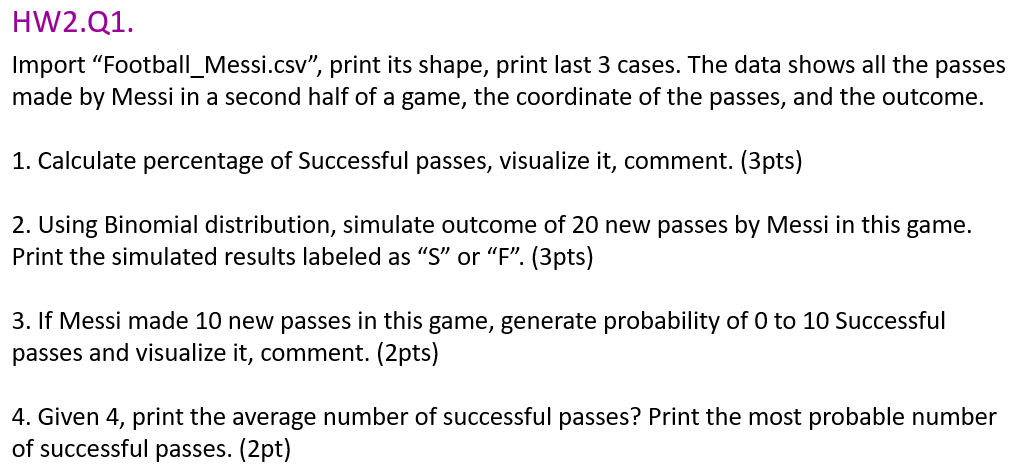

In [ ]:
Image('http://abolfazlsaghafi.info/wp-content/uploads/2024/09/HW2Q1.png')

### Part 0
Import "Football_Messi.csv", print its shape, print last 3 cases.

In [ ]:
# import dataframe
messi = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/Football_Messi.csv")

# print shape
print("Shape of dataframe:", messi.shape)

# print last three cases
messi.tail(3)

Shape of dataframe: (49, 9)


,player,minute,second,x,y,type,outcome,endX,endY
46,messi,91,18,66,31,Pass,Successful,76,20
47,messi,91,46,74,38,Pass,Unsuccessful,76,36
48,messi,94,7,57,37,Pass,Unsuccessful,90,54


### Part 1
Calculate percentage of Successful passes, visualize it, comment. (3pts)

In [ ]:
# calculate percentage of successful passes

# declare variables for calculation
outcome             = messi["outcome"]
total_passes        = messi.shape[0]
successful_passes   = messi[outcome == "Successful"].shape[0]
unsuccessful_passes = messi[outcome == "Unsuccessful"].shape[0]

# calculate and display
rate_success     = successful_passes / total_passes
rate_success

0.8163265306122449

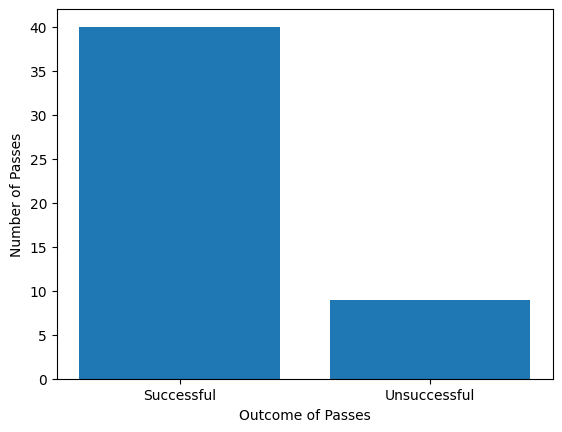

In [ ]:
# visualize percentage of successful passes

# declare variables for visualization
counts   = [successful_passes, unsuccessful_passes]
outcomes = ["Successful", "Unsuccessful"]

# create visualization (bar plot)
plt.bar(outcomes, counts)
plt.ylabel("Number of Passes")
plt.xlabel("Outcome of Passes")
plt.show()

In [ ]:
# comment on percentage of successful passes

# print message
percent_success      = rate_success * 100     # convert decimal to percentage
percent_unsuccessful = (unsuccessful_passes / total_passes) * 100
print("Messi's passes are successful", format(percent_success, ".2f"),
      "% of the time, while they are unsuccessful only",
      format(percent_unsuccessful, ".2f"), "% of the time.")

Messi's passes are successful 81.63 % of the time, while they are unsuccessful only 18.37 % of the time.


### Part 2
Using Binomial distribution, simulate outcome of 20 new passes by Messi in this game. Print the simulated results labeled as "S" or "F". (3pts)

In [ ]:
# simulate outcome of 20 new passes by Messi

# declare variable
num_passes = 20

# simulate outcomes
simulated_outcomes = np.random.binomial(n = 1, p = rate_success, size = num_passes)
simulated_outcomes

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1])

In [ ]:
# print the simulated results as "S" or "F"
print("Results:")
for i in simulated_outcomes:
  if i == 1:
    print("S", end = " ")
  else:
    print("F", end = " ")

Results:
S S S S S S S S S S F S S F S S F S S S 

### Part 3
If Messi made 10 new passes in this game, generate probability of 0 to 10 Successful passes and visualize it, comment. (2pts)

In [ ]:
# generate probabilities of 0 to 10 successful passes

# use probability mass function for binomial distribution

# declare variables, carry over rate_success from earlier Part
num_passes = 10
x = np.arange(0, num_passes + 1)

# calculate and display binomial PMF
probabilities = binom.pmf(x, num_passes, rate_success)
print(probabilities)

[4.36982751e-08 1.94214556e-06 3.88429112e-05 4.60360429e-04
 3.58058111e-03 1.90964326e-02 7.07275281e-02 1.79625468e-01
 2.99375780e-01 2.95679783e-01 1.31413237e-01]


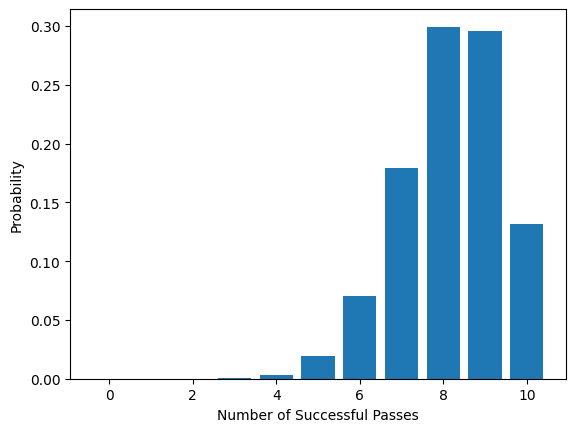

In [ ]:
# create visualization (barplot)
plt.bar(x, probabilities)
plt.xlabel('Number of Successful Passes')
plt.ylabel('Probability')
plt.show()

Comment on probabilities of successful passes:

Using the success rate from Part 1 (81.63%), if Messi were to attempt 10 more passes, he is most likely to successfully complete 8 of them (at a probability of 29.94%). The second most likely outcome would be him successfully completing 9 passes (29.57%). There is an incredibly small probability that he would only successfully complete less than 5 passes.

### Part 4
Given 4, print the average number of successful passes? Print the most probable number of successful passes. (2pt)

In [ ]:
# calculate and print average number of successful passes
avg_passes = num_passes * rate_success
print("The average number of successful passes is", format(avg_passes, ".2f"))

# print most probable number of successful passes (based on Part 3)
print("The most probable number of successful passes is 8")

The average number of successful passes is 8.16
The most probable number of successful passes is 8


## Question 2



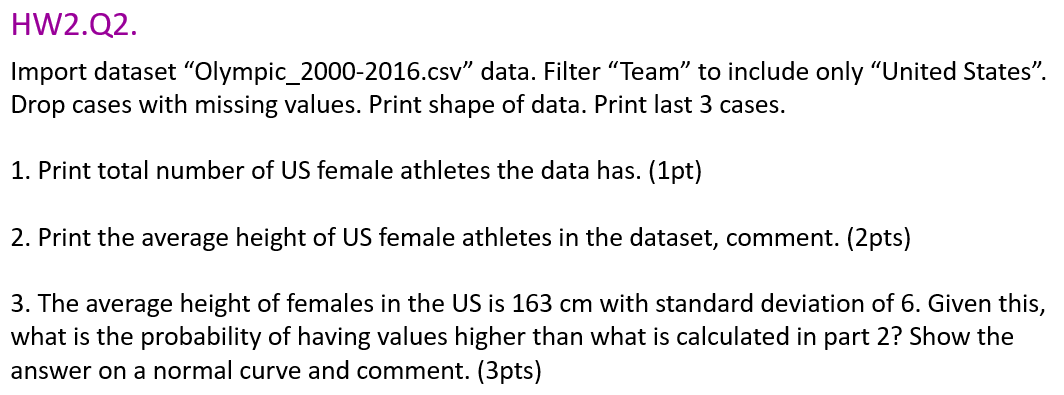

In [ ]:
Image('http://abolfazlsaghafi.info/wp-content/uploads/2024/09/HW2Q2.png')

### Part 0
Import dataset "Olympic_2000-2016.csv" data. Filter "Team" to include only "United States". Drop cases with missing values. Print shape of data. Print last 3 cases.

In [ ]:
# import dataset
olympic = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/Olympic_2000-2016.csv")

# filter "Team" to include only "United States"
olympic = olympic[olympic["Team"] == "United States"]

# drop cases with missing values
olympic.dropna(inplace = True)

# print shape of data
print("Shape of dataframe:", olympic.shape)

# print last 3 cases
olympic.tail(3)

Shape of dataframe: (1556, 13)


,Name,Sex,Age,Height,Weight,Team,NOC,Year,Season,City,Sport,Event,Medal
84774,Kelsi Worrell,F,22.0,180.0,75.0,United States,USA,2016,Summer,Rio de Janeiro,Swimming,Swimming Women's 4 x 100 metres Medley Relay,Gold
84779,Dagmara Wozniak (Woniak-),F,28.0,173.0,81.0,United States,USA,2016,Summer,Rio de Janeiro,Fencing,"Fencing Women's Sabre, Team",Bronze
85050,Mariel Leigh Zagunis,F,31.0,173.0,72.0,United States,USA,2016,Summer,Rio de Janeiro,Fencing,"Fencing Women's Sabre, Team",Bronze


### Part 1
Print total number of US female athletes the data has. (1pt)

In [ ]:
# print total number of US female athletes in the data
female_athletes = olympic[olympic["Sex"] == "F"]
print("Number of US female athletes:", female_athletes.shape[0])

Number of US female athletes: 843


### Part 2
Print the average height of US female athletes in the dataset, comment. (2pts)

In [ ]:
# print the average height of US female athletes
avg_height = female_athletes["Height"].mean()
print("Average height of US female athletes:", format(avg_height, ".2f"), "cm")

Average height of US female athletes: 173.29 cm


### Part 3
The average height of females in the US is 163 cm with standard deviation of 6. Given this, what is the probability of having values higher than what is calculated in part 2? Show the answer on a normal curve and comment. (3pts)

In [ ]:
# find probability of having higher height values

# using typical method (CDF)

# given variables
US_avg_height = 163
std = 6
# avg_height is the same from Part 2

# calculate z-score
z = (avg_height - US_avg_height) / std
prob_under173 = stats.norm.cdf(z)
prob_over173 = 1 - prob_under173

# print percent probability of having a height over 173.29 cm
print("Probability of having a height over 173.29 cm:", format(prob_over173 * 100, ".2f"), "%")

Probability of having a height over 173.29 cm: 4.32 %


Probability of x > 173.29 cm in Normal Distibution N(163, 6) is: 4.32 %


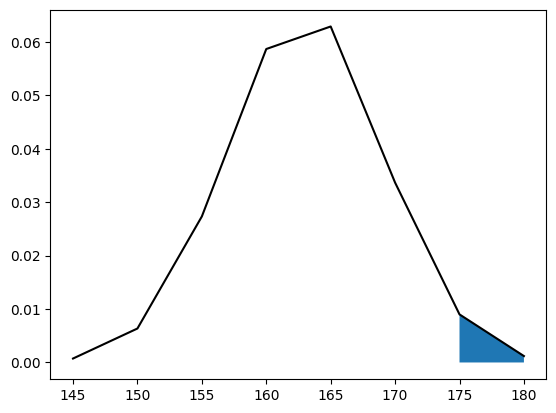

In [ ]:
# find probability of having higher height values and visualize on normal curve

# using method from class examples (draw_norm_score)

# def from Week 4 codes:
def draw_norm_score(x, cond, loc, scale):
    y = norm.pdf(x, loc, scale)
    z = x[cond]
    plt.plot(x, y, 'k')
    plt.fill_between(z, 0, norm.pdf(z, loc, scale))
    plt.show()

# substitute in values for x, loc, and scale
prob = norm.cdf(x = 173.29, loc = 163, scale = 6)
print("Probability of x > 173.29 cm in Normal Distibution N(163, 6) is:", format((1 - prob) * 100, ".2f"), "%")
x = np.arange(163 - 3, 163 + 3, 5)
draw_norm_score(x, x > 173, 163, 6)

Comment on the probability of having values higher than what was calculated in Part 2:

Using both the cummulative distribution function and the draw_norm_score methods show that there is only a 4.32% probability that a randomly-selected US Female would be taller than the average US Female Olympian.

* I used CDF as it was what I am most accustomed to in my other DSC courses, but I also remembered the draw_norm_score method from class examples, so I figured I would use both as the former is more clear on the calculations, while only the latter provides visualizations.

## Question 3



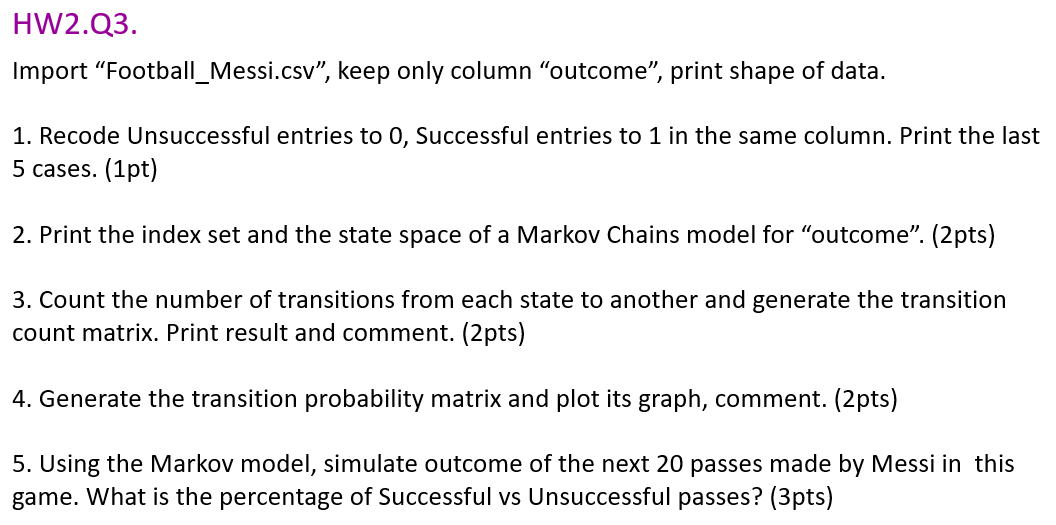

In [ ]:
Image('http://abolfazlsaghafi.info/wp-content/uploads/2024/09/HW2Q3.png')

### Part 0
Import "Football_Messi.csv", keep only column "outcome", print shape of data.

In [ ]:
# dataframe already imported in Question 1

# keep only column "outcome"
messi = messi[["outcome"]]

# print shape of data
print("Shape of dataframe:", messi.shape)
messi

Shape of dataframe: (49, 1)


,outcome
0,Successful
1,Successful
2,Successful
3,Successful
4,Unsuccessful
5,Successful
6,Unsuccessful
7,Successful
8,Successful
9,Unsuccessful


### Part 1
Recode Unsuccessful entries to 0, Successful entries to 1 in the same column. Print the last 5 cases. (1pt)

In [ ]:
# recode Unsuccessful entries to 0, Successful entries to 1 in the same column

# NOTE: because the function recodes to the same column, only run once,
# delete runtime in order to run multiple times, otherwise all values will be recoded to 0

messi["outcome"] = np.where(messi["outcome"] == "Successful", 1, 0)

# print the last 5 cases
messi.tail(5)

,outcome
44,1
45,0
46,1
47,0
48,0


### Part 2
Print the index set and the state space of a Markov Chains model for "outcome". (2pts)

In [ ]:
# create sequence array of outcomes, list of state names (from Week 5 codes)
states = [0, 1]
states_names = ["Unsuccessful", "Successful"]
sequence = messi["outcome"].to_numpy()

# make a list of all transitions
sequence_transitions = get_transition_tuples(sequence)
print(sequence_transitions)

[(1, 1), (1, 1), (1, 1), (1, 0), (0, 1), (1, 0), (0, 1), (1, 1), (1, 0), (0, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 0), (0, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 0), (0, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 0), (0, 1), (1, 1), (1, 0), (0, 1), (1, 0), (0, 0)]


### Part 3
Count the number of transitions from each state to another and generate the transition count matrix. Print result and comment. (2pts)

In [ ]:
# count number of transitions from each state to another
# generate transition count matrix
Nxy = pd.DataFrame(0, index=states_names, columns=states_names)
for i, j in sequence_transitions:
    Nxy.loc[states_names[i], states_names[j]] += 1
print(Nxy)

              Unsuccessful  Successful
Unsuccessful             1           7
Successful               8          32


### Part 4
Generate the transition probability matrix and plot its graph, comment. (2pts)

              Unsuccessful  Successful
Unsuccessful         0.125       0.875
Successful           0.200       0.800


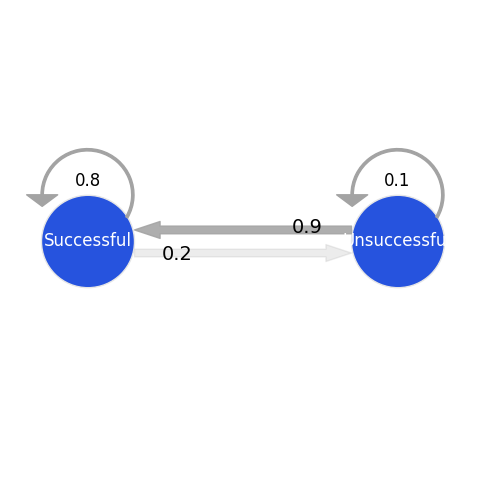

In [ ]:
# generate transition probability matrix
Pxy = Nxy.div(Nxy.sum(axis=1), axis=0).fillna(0.00)
Pxy = Pxy.round(decimals=3)
print(Pxy)

# plot transition probability matrix graph
mc = MarkovChain(Pxy.to_numpy(), states_names)
mc.draw()

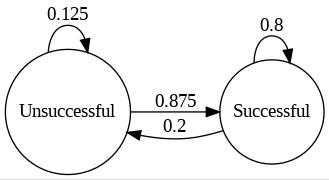

In [ ]:
# alternative plot of transition probability matrix graph
render_graph('transition_prob', Pxy, states_names)
Image('/content/transition_prob.jpeg')

Comment on transition probability matrix:

It is clear that Messi is most likely to successfully complete a pass, and he actually has a higher probability to make a pass after failing the pass before (87.5% probability) than if he were to make consecutive successful passes (80% probability).

### Part 5
Using the Markov model, simulate outcome of the next 20 passes made by Messi in this game. What is the percentage of Successful vs Unsuccessful passes? (3pts)

In [ ]:
# using Markov, simulate outcome of the next 20 passes

# pass #49 was Unsuccessful, so initial position is Unsuccessful
initial_prob = np.array([1, 0])
sims = sim_steps(Pxy, 20, initial_prob)
print(sims)

[0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1]


In [ ]:
# calculate percentage of Successful vs Unsuccessful passes
percent_success = np.count_nonzero(sims == 1) / len(sims) * 100
percent_unsuccessful = np.count_nonzero(sims == 0) / len(sims) * 100

# print percentage of Successful vs Unsuccessful passes
print("Percentage of Successful passes:  ", percent_success, "%")
print("Percentage of Unsuccessful passes:", percent_unsuccessful, "%")

Percentage of Successful passes:   80.0 %
Percentage of Unsuccessful passes: 20.0 %
